In [11]:
from stable_baselines3 import PPO
from stable_baselines3.ppo.policies import MlpPolicy
from stable_baselines3.common.monitor import Monitor
import gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3.common.evaluation import evaluate_policy

# Half Cheetah environment
> Half cheetah has 9 links and 8 joints
* Action space: Applying torque for 6 joints (excluding the head and torso). Torque values ranging from -1.0 to +1.0 (continuous values)
* Observation space: (17,) vector describing various position, angle and velocities on the body
* Episode ends: Each episode runs for a fixed timesteps of 1000
* Rewards: forward_reward - ctrl_cost (Check for the definitions from [https://www.gymlibrary.dev/environments/mujoco/half_cheetah/#rewards](https://www.gymlibrary.dev/environments/mujoco/half_cheetah/#rewards))


In [17]:
env_id = 'HalfCheetah-v3'  # MuJoCo simulator is needed for this env
env = gym.make(env_id)

In [18]:
# Wrap the env with the Monitor wrapper for proper reporting of episode lengths and rewards
env = Monitor(env)

In [19]:
# Let's see the reward threshold
env.spec.reward_threshold

4800.0

In [3]:
# Run this command to install the necessary packages for MuJoCo to work properly on Linux system.
# If you're using PyCharm in Linux, run it from terminal.
# sudo apt install libosmesa6-dev libgl1-mesa-glx libglfw3 patchelf xvfb ffmpeg

In [30]:
model = PPO(MlpPolicy, env, verbose=0, device='cpu')

In [35]:
model.learn(total_timesteps=1e6)

KeyboardInterrupt: 

In [34]:
def eval_model(mdl, env_in, num_eps=50):
    eps_rewards, eps_lengths = evaluate_policy(mdl, env_in, n_eval_episodes=num_eps, return_episode_rewards=True)
    print('Mean reward', np.mean(eps_rewards))
    print('Std reward', np.std(eps_rewards))
    print('Mean episode length', np.mean(eps_lengths))
    plt.plot(range(len(eps_rewards)), eps_rewards)
    plt.show()

Mean reward 1582.6972461599998
Std reward 65.36882325121668
Mean episode length 1000.0


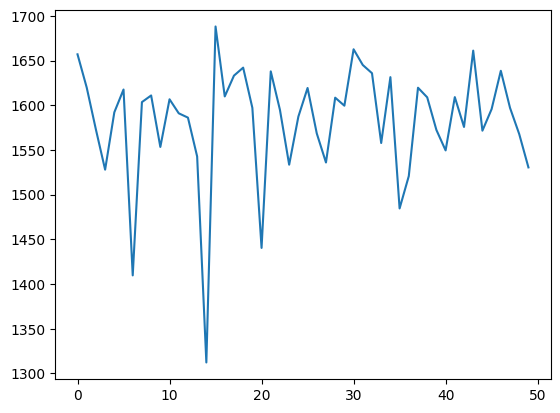

In [36]:
eval_model(model, env)

In [27]:
# Set up fake display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [28]:
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

def record_video(env_iden, mdl, video_length=500, prefix='', video_folder='videos/'):
  eval_env = DummyVecEnv([lambda: gym.make(env_iden)])
  # Start the video at step=0 and record 500 steps
  eval_env = VecVideoRecorder(eval_env, video_folder=video_folder,
                              record_video_trigger=lambda step: step == 0, video_length=video_length,
                              name_prefix=prefix)

  obs = eval_env.reset()
  for _ in range(video_length):
    action, _ = mdl.predict(obs)
    obs, _, _, _ = eval_env.step(action)

  # Close the video recorder
  eval_env.close()

In [33]:
record_video(env_id, model, video_length=500, prefix='ppo-'+env_id)

Saving video to /home/nikhil/PycharmProjects/RL_Algorithms_Survey/Half Cheetah/videos/ppo-HalfCheetah-v3-step-0-to-step-500.mp4
